# Libraries

In [837]:
import matplotlib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, SelectKBest, SelectPercentile, SelectFromModel, RFE
from pathlib import Path

In [816]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Constants

In [817]:
RAW_DATA_PATH = Path("C:/Users/TUF15/Desktop/D4GEN/d4gen_project/data/raw/raw_dataset.csv")
PREPARED_TRAIN_DATA = Path("C:/Users/TUF15/Desktop/D4GEN/d4gen_project/data/prepared/train.csv")
PREPARED_TEST_DATA = Path("C:/Users/TUF15/Desktop/D4GEN/d4gen_project/data/prepared/test.csv")

# Reading data

In [818]:
raw_dataset = pd.read_csv(RAW_DATA_PATH, delimiter=';')

In [819]:
print ('Database has %i rows and %i columns' % (raw_dataset.shape[0], raw_dataset.shape[1]))

Database has 1950 rows and 397 columns


# Initial data management

In [820]:
prepared_dataset = raw_dataset.copy()

# Elimination des lignes/colonnes vides
prepared_dataset = prepared_dataset.dropna(how='all')

def normalize_column(column_name: str):
    return str(column_name.replace(' ', '_') \
                          .replace('é', 'e') \
                          .replace('à', 'a') \
                          .replace("'", '_').upper())

# Normalisation des noms des colonnes
for i, c in enumerate(prepared_dataset.columns):
    prepared_dataset = prepared_dataset.rename(columns={c: normalize_column(c)})

# Selection des colonnes intéréssantes
# A ajouter ECPL_ETT_TXT, ECPL_SCOP_TXT, ECPL_HOLTER_TXT
ml_dataset = prepared_dataset[
    [
        'AGE', 'ATCD_CONSO_ALCOOL', 'ATCD_DIABETE', 'ATCD_FA_CONNU', 'ATCD_HTA', 'BIO_CPK',
        'BIO_CRP', 'BIO_LDL', 'BIO_NTPROBNP', 'BIO_POTASSIUM', 'BIO_HBA1C', 'BIO_TROPONINE', 'BIO_TSH3G',
        'CDS_EE_AUTRE', 'CDS_EE_AUTRE_TEXT', 'CDS_EE_ETO', 'CDS_EE_ETT', 'CDS_EE_HECGTYPE', 'ECG_A_L_ARRIVEE',
        'ECPL_BIO_NTPROBNP', 'ECPL_ETT', 'ECPL_HOLTER', 'ECPL_SCOP',
        'ETIO_CE_FA', 'CDS_EE_HECG', 'ETIO_TOAST', 'FA_SUR_ECGSCOPEHOLTERREVEAL', 'ICI_ASPECT', 'ICI_IRM_NONLAC_D_ACM',
        'ICI_SWAN_THROMBUS', 'NIHSS_INITIAL', 'ICI_IRM_LAC', 'SEXE', 'UNITE_ALCOOL/SEM'
    ]
]

ml_dataset.shape

(1950, 34)

In [821]:
###########################################
# CATEGORICAL FEATURES
###########################################
# BIO_CPK, BIO_CRP, BIO_NTPROBNP, BIO_POTASSIUM : Numérique ou pas ? contient des valeurs non numériques
# ICI_ASPECT,  : est elle numérique ou catégorique ?
categorical_features = [
    'BIO_CPK', 'BIO_CRP', 'BIO_NTPROBNP', 'BIO_POTASSIUM', 'BIO_HBA1C', 'BIO_TROPONINE',
    'BIO_TSH3G', 'CDS_EE_AUTRE', 'CDS_EE_AUTRE_TEXT', 'CDS_EE_ETO', 'CDS_EE_ETT', 'CDS_EE_HECGTYPE',
    'ECG_A_L_ARRIVEE', 'ECPL_ETT', 'ECPL_HOLTER', 'ECPL_SCOP', 'ETIO_CE_FA', 'CDS_EE_HECG',
    'ETIO_TOAST', 'FA_SUR_ECGSCOPEHOLTERREVEAL', 'ICI_ASPECT', 'ICI_IRM_NONLAC_D_ACM', 'ICI_SWAN_THROMBUS',
    'ICI_IRM_LAC', 'SEXE', 'ATCD_CONSO_ALCOOL', 'ATCD_DIABETE', 'ATCD_FA_CONNU', 'ATCD_HTA'
]
mapping_categorical_features_values = dict()
for feature in categorical_features:
    mapping_categorical_features_values[feature] = dict()
    for i, v in enumerate(ml_dataset[feature].unique()):
        mapping_categorical_features_values[feature][v] = i
        ml_dataset.loc[ml_dataset[feature] == v, feature] = i
        
###########################################
# NUMERICAL FEATURES
###########################################
numerical_features = [
    'AGE', 'BIO_LDL', 'ECPL_BIO_NTPROBNP', 'ICI_ASPECT', 'NIHSS_INITIAL', 'UNITE_ALCOOL/SEM'
]
for feature in numerical_features:
    if ml_dataset[feature].dtype == 'object':
        ml_dataset.loc[:, feature] = ml_dataset[feature].str.replace(' ', '') 
    ml_dataset.loc[:, feature] = pd.to_numeric(ml_dataset[feature])

###########################################
# TEXTUAL FEATURES
###########################################
# Faut-il enlever cette feature ?
# text_features = [
#     'ECPL_HOLTER_TXT', 'ECPL_SCOP_TXT'
# ]
text_features = [
]

# A compléter

###########################################
# TEXTUAL FEATURES -> TOKENS
###########################################
# Extraction des features à partir de ces colonnes
# tokens_to_categorical_features = ['ECPL_ETT_TXT']
tokens_to_categorical_features = []

# A compléter

In [822]:
ml_dataset['__TARGET__'] = ml_dataset['FA_SUR_ECGSCOPEHOLTERREVEAL']
del ml_dataset['FA_SUR_ECGSCOPEHOLTERREVEAL']

# Remove rows for which the target is unknown.
ml_dataset = ml_dataset[~ml_dataset['__TARGET__'].isnull()]
ml_dataset['__TARGET__'] = ml_dataset['__TARGET__'].astype(np.int64)

# Train/Test strategy

In [826]:
X = ml_dataset.drop(columns=['__TARGET__'])
y = ml_dataset['__TARGET__']

# split data into training and testing sets, stratified by y
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

print ('Train data has %i rows and %i columns' % (X_train.shape[0], X_train.shape[1]))
print ('Test data has %i rows and %i columns' % (X_test.shape[0], X_test.shape[1]))

Train data has 872 rows and 33 columns
Test data has 218 rows and 33 columns


---

# Features preprocessing

In [827]:
###########################################
# Supprimer la ligne entière lorsque la colonne est vide
###########################################
drop_rows_when_missing = []
for feature in drop_rows_when_missing:
    X_train = X_train[X_train[feature].notnull()]
    X_test = X_test[X_test[feature].notnull()]
    print ('Dropped missing records in %s' % feature)

###########################################
# Remplissage des champs vides
###########################################
impute_when_missing = [
    {'feature': 'AGE', 'impute_with': 'MEAN'},
    {'feature': 'ATCD_CONSO_ALCOOL', 'impute_with': 'MODE'},
    {'feature': 'ATCD_DIABETE', 'impute_with': 'MODE'},
    {'feature': 'ATCD_FA_CONNU', 'impute_with': 'MODE'},
    {'feature': 'ATCD_HTA', 'impute_with': 'MODE'},
    {'feature': 'BIO_CPK', 'impute_with': 'MODE'},
    {'feature': 'BIO_CRP', 'impute_with': 'MODE'},
    {'feature': 'BIO_LDL', 'impute_with': 'MODE'},
    {'feature': 'BIO_NTPROBNP', 'impute_with': 'MODE'},
    {'feature': 'BIO_POTASSIUM', 'impute_with': 'MODE'},
    {'feature': 'BIO_HBA1C', 'impute_with': 'MODE'},
    {'feature': 'BIO_TROPONINE', 'impute_with': 'MODE'},
    {'feature': 'BIO_TSH3G', 'impute_with': 'MODE'},
    {'feature': 'CDS_EE_AUTRE', 'impute_with': 'MODE'},
    {'feature': 'CDS_EE_AUTRE_TEXT', 'impute_with': 'MODE'},
    {'feature': 'CDS_EE_ETO', 'impute_with': 'MODE'},
    {'feature': 'CDS_EE_ETT', 'impute_with': 'MODE'},
    {'feature': 'CDS_EE_HECGTYPE', 'impute_with': 'MODE'},
    {'feature': 'ECG_A_L_ARRIVEE', 'impute_with': 'MODE'},
    {'feature': 'ECPL_BIO_NTPROBNP', 'impute_with': 'MODE'},
    {'feature': 'ECPL_ETT', 'impute_with': 'MODE'},
    {'feature': 'ECPL_HOLTER', 'impute_with': 'MODE'},
    {'feature': 'ECPL_SCOP', 'impute_with': 'MODE'},
    {'feature': 'ETIO_CE_FA', 'impute_with': 'MODE'},
    {'feature': 'CDS_EE_HECG', 'impute_with': 'MODE'},
    {'feature': 'ETIO_TOAST', 'impute_with': 'MODE'},
    {'feature': 'ICI_ASPECT', 'impute_with': 'MODE'},
    {'feature': 'ICI_IRM_NONLAC_D_ACM', 'impute_with': 'MODE'},
    {'feature': 'ICI_SWAN_THROMBUS', 'impute_with': 'MODE'},
    {'feature': 'NIHSS_INITIAL', 'impute_with': 'MODE'},
    {'feature': 'ICI_IRM_LAC', 'impute_with': 'MODE'},
    {'feature': 'SEXE', 'impute_with': 'MODE'},
    {'feature': 'UNITE_ALCOOL/SEM', 'impute_with': 'MODE'}
]
for feature in impute_when_missing:
    if feature['impute_with'] == 'MEAN':
        v = X_train[feature['feature']].mean()
    elif feature['impute_with'] == 'MEDIAN':
        v = X_train[feature['feature']].median()
    elif feature['impute_with'] == 'CREATE_CATEGORY':
        v = 'NULL_CATEGORY'
    elif feature['impute_with'] == 'MODE':
        v = X_train[feature['feature']].value_counts().index[0]
    elif feature['impute_with'] == 'CONSTANT':
        v = feature['value']
    X_train[feature['feature']] = X_train[feature['feature']].fillna(v)
    X_test[feature['feature']] = X_test[feature['feature']].fillna(v)
    print ('Imputed missing values in feature %s with value %s' % (feature['feature'], v))

Imputed missing values in feature AGE with value 70.46091954022988
Imputed missing values in feature ATCD_CONSO_ALCOOL with value 0
Imputed missing values in feature ATCD_DIABETE with value 0
Imputed missing values in feature ATCD_FA_CONNU with value 0
Imputed missing values in feature ATCD_HTA with value 0
Imputed missing values in feature BIO_CPK with value 20
Imputed missing values in feature BIO_CRP with value 3
Imputed missing values in feature BIO_LDL with value 1.18
Imputed missing values in feature BIO_NTPROBNP with value 9
Imputed missing values in feature BIO_POTASSIUM with value 2
Imputed missing values in feature BIO_HBA1C with value 4
Imputed missing values in feature BIO_TROPONINE with value 235
Imputed missing values in feature BIO_TSH3G with value 19
Imputed missing values in feature CDS_EE_AUTRE with value 1
Imputed missing values in feature CDS_EE_AUTRE_TEXT with value 13
Imputed missing values in feature CDS_EE_ETO with value 1
Imputed missing values in feature CDS_E

# Columns rescaling

In [828]:
rescale_features = {
    'AGE': 'AVGSTD',
    'BIO_LDL': 'AVGSTD',
    'ECPL_BIO_NTPROBNP': 'AVGSTD',
    'ICI_ASPECT': 'AVGSTD',
    'NIHSS_INITIAL': 'AVGSTD',
    'UNITE_ALCOOL/SEM': 'AVGSTD'
    }

for (feature_name, rescale_method) in rescale_features.items():
    if rescale_method == 'MINMAX':
        _min = train[feature_name].min()
        _max = train[feature_name].max()
        scale = _max - _min
        shift = _min
    else:
        shift = X_train[feature_name].mean()
        scale = X_train[feature_name].std()
    if scale == 0.:
        del X_train[feature_name]
        del X_test[feature_name]
        print ('Feature %s was dropped because it has no variance' % feature_name)
    else:
        print ('Rescaled %s' % feature_name)
        X_train[feature_name] = (X_train[feature_name] - shift).astype(np.float64) / scale
        X_test[feature_name] = (X_test[feature_name] - shift).astype(np.float64) / scale

Rescaled AGE
Rescaled BIO_LDL
Rescaled ECPL_BIO_NTPROBNP
Rescaled ICI_ASPECT
Rescaled NIHSS_INITIAL
Rescaled UNITE_ALCOOL/SEM


# Saving datasets

In [829]:
RAW_DATA_PATH = Path("C:/Users/TUF15/Desktop/D4GEN/d4gen_project/data/raw/raw_dataset.csv")
PREPARED_TRAIN_DATA = Path("C:/Users/TUF15/Desktop/D4GEN/d4gen_project/data/prepared/train.csv")
PREPARED_TEST_DATA = Path("C:/Users/TUF15/Desktop/D4GEN/d4gen_project/data/prepared/test.csv")

In [832]:
X_train.join(y_train).to_csv(PREPARED_TRAIN_DATA)
X_test.join(y_test).to_csv(PREPARED_TEST_DATA)

# PCA

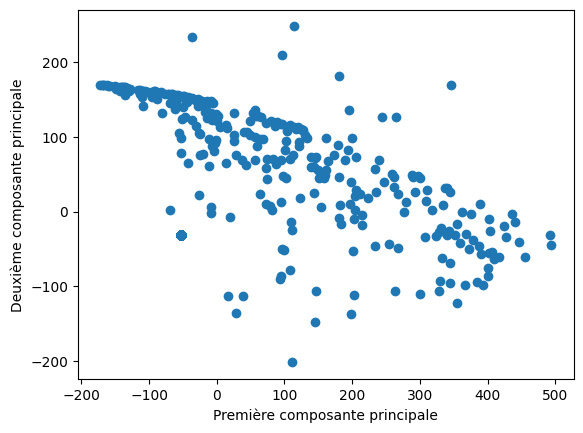

In [838]:
from sklearn.decomposition import PCA
# appliquer la PCA sur les vecteurs numériques
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# visualiser les résultats de la PCA
df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel("Première composante principale")
plt.ylabel("Deuxième composante principale")
plt.show()

# Modeling

In [739]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## Random forest

In [794]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=5,
    min_samples_leaf=10,
    verbose=2
)

In [795]:
%time clf.fit(X_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(max_depth=5, min_samples_leaf=10, random_state=42,
                       verbose=2)

### Cross validation

In [796]:
# accuracy, balanced_accuracy, roc_auc, f1, neg_mean_absolute_error, neg_root_mean_squared_error, r2
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Paral

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [797]:
scores

array([0.86021505, 0.78651685, 0.81318681, 0.91836735, 0.82105263])

In [798]:
scores.mean()

0.8398677398801123

### Features selection

In [799]:
# SelectKBest, SelectPercentile, SelectFromModel et RFE (Recursive Feature Elimination)
selector = SelectFromModel(clf, prefit=True)
# selector = SelectKBest(chi2, k=2)
# X_train_new = selector.fit_transform(X, y)
X_train_new = selector.transform(X_train)
print(X_train_new.shape)
print(X_train.columns[selector.get_support()])

(872, 6)
Index(['AGE', 'ATCD_FA_CONNU', 'ECG_A_L_ARRIVEE', 'ECPL_BIO_NTPROBNP',
       'ETIO_TOAST', 'NIHSS_INITIAL'],
      dtype='object')


### Results

In [800]:
%time _predictions = clf.predict(X_test)
%time _probas = clf.predict_proba(X_test)
_predictions
predictions = pd.Series(data=_predictions, index=X_test.index, name='predicted_value')
cols = [
    'probability_of_value_0',
    'probability_of_value_1'
]
probabilities = pd.DataFrame(data=_probas, index=X_test.index, columns=cols)

# Build scored dataset
results_test = X_test.join(predictions, how='left')
results_test = results_test.join(probabilities, how='left')
results_test = results_test.join(test['__TARGET__'], how='left')
results_test = results_test.rename(columns= {'__TARGET__': 'FA_SUR_ECGSCOPEHOLTERREVEAL'})

CPU times: total: 0 ns
Wall time: 9 ms
CPU times: total: 0 ns
Wall time: 7 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Features importances

<Axes: title={'center': 'Top 10 most important variables'}, ylabel='feature'>

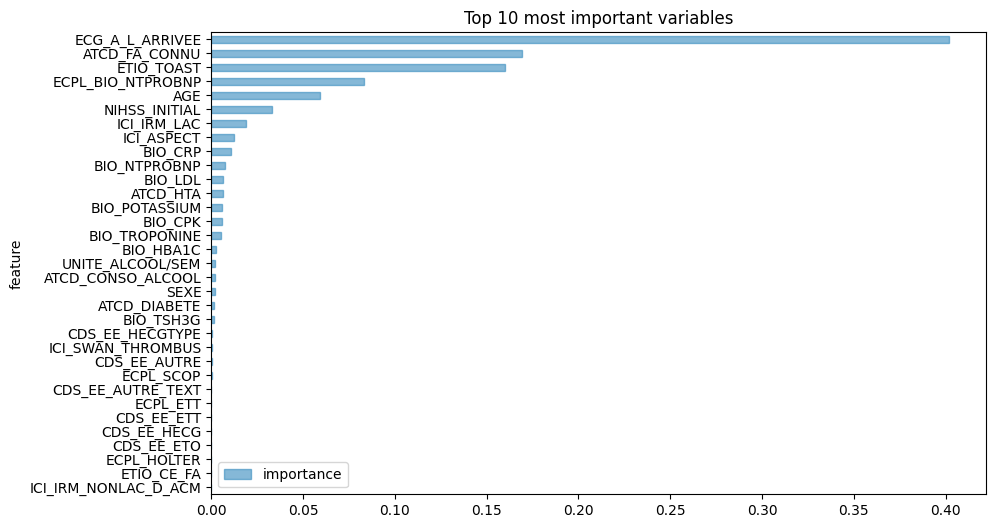

In [801]:
feature_importances_data = []
features = X_train.columns
for feature_name, feature_importance in zip(features, clf.feature_importances_):
    feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
pd.DataFrame(feature_importances_data)\
    .set_index('feature')\
    .sort_values(by='importance', ascending=True) \
    .plot(title='Top 10 most important variables',
          kind='barh',
          figsize=(10, 6),
          color='#348ABD',
          alpha=0.6,
          lw=1.,
          edgecolor='#348ABD',
          grid=False,)

---

### Metrics

#### Confusion matrix

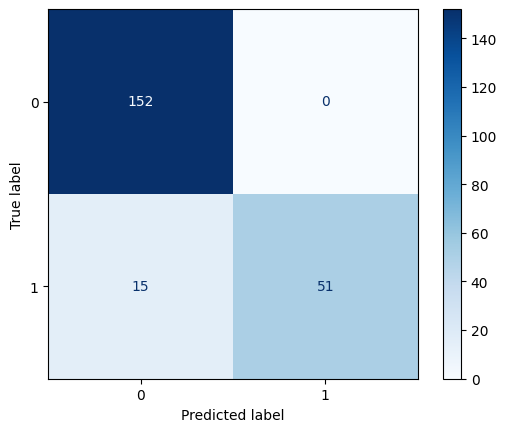

In [802]:
cm = confusion_matrix(y_test, _predictions)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

#### Precision Recall curve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


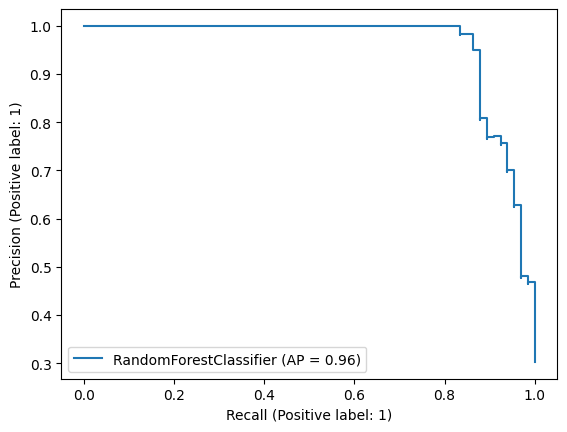

In [803]:
display = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

#### Other metrics

In [804]:
print('F1 score :', round(f1_score(y_test, predictions), 4))
print('Precision :', round(precision_score(y_test, predictions), 4))
print('Recall :', round(recall_score(y_test, predictions), 4))
print('Mean Squared Error (MSE):', round(mean_squared_error(y_test, predictions), 4))
print('Root Mean Squared Error (RMSE):', round(mean_squared_error(y_test, predictions, squared=False), 4))
print('Mean Absolute Percentage Error (MAPE):', round(mean_absolute_percentage_error(y_test, predictions), 4))
print('Explained Variance Score:', round(explained_variance_score(y_test, predictions), 4))
print('Max Error:', round(max_error(y_test, predictions), 4))
print('Mean Squared Log Error:', round(mean_squared_log_error(y_test, predictions), 4))
print('Median Absolute Error:', round(median_absolute_error(y_test, predictions), 4))
print('R^2:', round(r2_score(y_test, predictions), 4))

F1 score : 0.8718
Precision : 1.0
Recall : 0.7727
Mean Squared Error (MSE): 0.0688
Root Mean Squared Error (RMSE): 0.2623
Mean Absolute Percentage Error (MAPE): 0.0688
Explained Variance Score: 0.6965
Max Error: 1
Mean Squared Log Error: 0.0331
Median Absolute Error: 0.0
R^2: 0.674


---

## XGBoost

In [805]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                              random_state=42)

In [806]:
%time xgb_model.fit(X_train, y_train)

CPU times: total: 719 ms
Wall time: 56.5 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [807]:
xgb_predictions = xgb_model.predict(X_test)

In [808]:
%time _probas = clf.predict_proba(X_test)

CPU times: total: 0 ns
Wall time: 8 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [809]:
%time _xgb_predictions = clf.predict(X_test)
%time _xgb_probas = clf.predict_proba(X_test)
xgb_predictions = pd.Series(data=_xgb_predictions, index=X_test.index, name='predicted_value')
xgb_cols = [
    'probability_of_value_0',
    'probability_of_value_1'
]
xgb_probabilities = pd.DataFrame(data=_xgb_probas, index=X_test.index, columns=xgb_cols)

# Build scored dataset
xgb_results_test = X_test.join(xgb_predictions, how='left')
xgb_results_test = xgb_results_test.join(probabilities, how='left')
xgb_results_test = xgb_results_test.join(test['__TARGET__'], how='left')
xgb_results_test = xgb_results_test.rename(columns= {'__TARGET__': 'FA_SUR_ECGSCOPEHOLTERREVEAL'})

CPU times: total: 0 ns
Wall time: 8 ms
CPU times: total: 0 ns
Wall time: 7 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Features importances

<Axes: title={'center': 'Top 10 most important variables'}, ylabel='feature'>

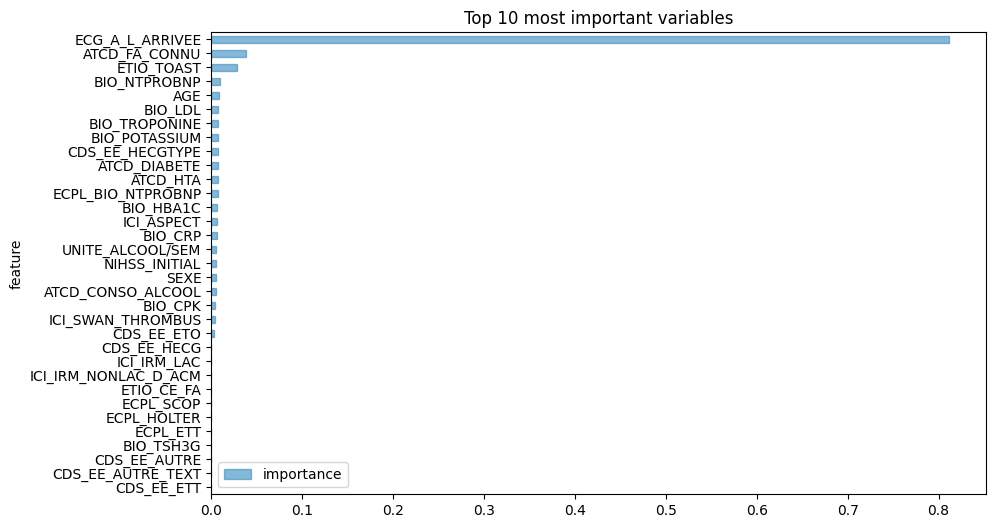

In [810]:
xgb_feature_importances_data = []
features = X_train.columns
for feature_name, feature_importance in zip(features, xgb_model.feature_importances_):
    xgb_feature_importances_data.append({
        'feature': feature_name,
        'importance': feature_importance
    })

# Plot the results
pd.DataFrame(xgb_feature_importances_data)\
    .set_index('feature')\
    .sort_values(by='importance', ascending=True) \
    .plot(title='Top 10 most important variables',
          kind='barh',
          figsize=(10, 6),
          color='#348ABD',
          alpha=0.6,
          lw=1.,
          edgecolor='#348ABD',
          grid=False,)

### Metrics

#### Confusion matrix

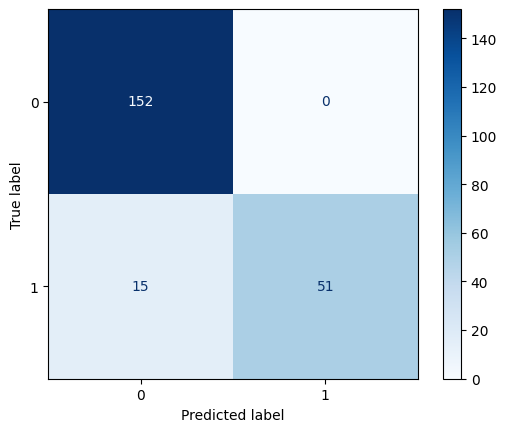

In [811]:
xgb_cm = confusion_matrix(y_test, _xgb_predictions)
ConfusionMatrixDisplay(xgb_cm).plot(cmap='Blues')

#### Precision Recall curve

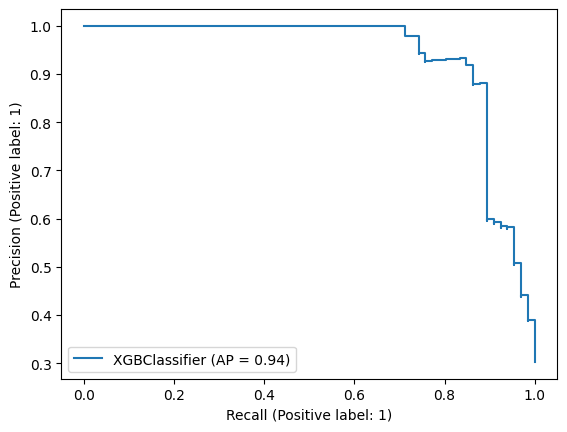

In [812]:
display = PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test)

#### Other metrics

In [813]:
print('F1 score :', round(f1_score(y_test, xgb_predictions), 4))
print('Precision :', round(precision_score(y_test, xgb_predictions), 4))
print('Recall :', round(recall_score(y_test, xgb_predictions), 4))
print('Mean Squared Error (MSE):', round(mean_squared_error(y_test, xgb_predictions), 4))
print('Root Mean Squared Error (RMSE):', round(mean_squared_error(y_test, xgb_predictions, squared=False), 4))
print('Mean Absolute Percentage Error (MAPE):', round(mean_absolute_percentage_error(y_test, xgb_predictions), 4))
print('Explained Variance Score:', round(explained_variance_score(y_test, xgb_predictions), 4))
print('Max Error:', round(max_error(y_test, xgb_predictions), 4))
print('Mean Squared Log Error:', round(mean_squared_log_error(y_test, xgb_predictions), 4))
print('Median Absolute Error:', round(median_absolute_error(y_test, xgb_predictions), 4))
print('R^2:', round(r2_score(y_test, xgb_predictions), 4))

F1 score : 0.8718
Precision : 1.0
Recall : 0.7727
Mean Squared Error (MSE): 0.0688
Root Mean Squared Error (RMSE): 0.2623
Mean Absolute Percentage Error (MAPE): 0.0688
Explained Variance Score: 0.6965
Max Error: 1
Mean Squared Log Error: 0.0331
Median Absolute Error: 0.0
R^2: 0.674
